# Getting started with the CEDA STAC API

This notebook outlines how to start using the CEDA STAC API, using the `pystac_client` python package. Note that the pystac_client itself has some [pretty good documentation](https://pystac-client.readthedocs.io/en/latest/usage.html) if any of this isn't clear or something isn't covered. 


## 1. Pystac-client
First we import `pystac_client` library.

In [1]:
import pystac_client
from pystac_client.stac_api_io import StacApiIO

Now we can define the url of the STAC catalog that we want to use, in this case the CEDA one but in principle any STAC-compliant catalog endpoint could be connected to. 

In [2]:
url = "https://api.stac.ceda.ac.uk/"

Now we make our client

In [3]:
client = pystac_client.Client.open(url)

And now we can start making calls to it. First up we can examine the collections available:

In [4]:
for coll in client.get_collections():
    print(f"{coll.id}: {coll.description}")

cmip6: CMIP6
cordex: CORDEX
sentinel1: Sentinel 1
sentinel2_ard: sentinel 2 ARD


We can take a closer look at the Sentinel 2 ARD collection by referencing its id with the `get_collection()` method.

In [5]:
sentinel2_ard = client.get_collection('sentinel2_ard')

We _could_ grab all it's related items like this but it would grab _ALL_ the items. We don't recommend it, this is better handled by searching - more on that later. 

In [6]:
sentinel2_ard.get_items()

<generator object CollectionClient.get_items at 0x1129285e0>

Note: just calling `get_items()` only creates a generator, we'd have to iterate over it to actually get all the items, i.e. 
```python
for item in sentinel2_ard.get_items():
    do stuff
```
but we're not doing that here. 

What we can do is check the spatial and temporal extent of the collection like so

In [7]:
sentinel2_ard.extent.spatial.bboxes

[[-9.00034454651177, 49.48562028352171, 3.1494256015866995, 61.33444247301668]]

In [8]:
[str(d) for d in sentinel2_ard.extent.temporal.intervals[0]]

['2023-01-01 11:14:51+00:00', '2023-11-01 11:43:49+00:00']

So we can see we have the satellite data between the 1st of Jan and 1st of November 2023, over the UK.

## 2. Searching

To make sure we're only looking at the items of interest we can use the search endpoint to slim down our possibilities, either using spatio-temporal values or other item-specific properties. This is all outlined [here](https://github.com/radiantearth/stac-api-spec/tree/release/v1.0.0/item-search), but we can show some of the features off here. 

Firstly temporal filtering, say we wanted to only get images from sentinel from January and February 2023, we would use the `client.search()` method:

In [9]:
item_search = client.search(
    collections=['sentinel2_ard'],
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
    ],
    max_items=10,
)

Here we've used the query kwarg to specify the start and end datetime for our search range, and these are all _and_-ed together so we get the range we want. There is a `datetime` kwarg on the search method, but this doesn't currently function as intended with the version of the STAC server we are running. This is a consequence of using `start_datetime` and `end_datetime` to provide a more consistent search interface across satellite images and model data, and _will be fixed in a future update._

Note as well that we've set `max_items` to 10 so we don't end up grabbing every item in the search result, you could remove this if you so desired. We've only specified one collection here but you can specify multiple, just bear in mind you always need to specify your collection(s) as a list - even if there's only one. 

We can interrogate our search results and see how many we matched:

In [10]:
# NOTE: for some reason this command sometimes fails on the first attempt, we're looking 
# into a fix. This just loops until it succeeds. 
for i in range(2):
    try:
        print(item_search.matched())
        break
    except KeyError as e:
        continue


1336


Grabbing only 10 of these now seems justified. We can iterate over our selected items, up to the length of `max_items`, with the `items()` method on the `item_search`. 

In [11]:
items = list(item_search.items())
items

[<Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat61lon033_T31VCH_ORB037_utm31n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat60lon04_T31VCG_ORB037_utm31n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat60lon023_T30VXM_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat57lon375_T30VVJ_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat56lon373_T30VVH_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat56lon211_T30VWH_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat56lon049_T30VXH_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat55lon37_T30UVF_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat55lon213_T30UWG_ORB037_utm30n_osgb>,
 <Item id=neodc.senti

In [12]:
len(items)

10

As expected we have 10 items in our list. We can then loop through and look at the metadata if we want to.

In [13]:
for item in items:
    print(item.properties["start_datetime"], item.properties["end_datetime"])

2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00
2023-02-28T11:21:19+00:00 2023-02-28T11:21:19+00:00


Note that we could get to the same result by manually polling the API endpoint with a get request. This could be browsed to on any web browser with the appropriate url, and in python this can be done nice and easily with the requests library. `item_search` also, very conveniently, has a method for pulling the url and query parameters out:

In [14]:
item_search.url_with_parameters()

'https://api.stac.ceda.ac.uk/search?collections=sentinel2_ard&query=%7B%22start_datetime%22%3A%7B%22gte%22%3A%222023-01-01%22%7D%2C%22end_datetime%22%3A%7B%22lte%22%3A%222023-02-28%22%7D%7D'

(NOTE: it doesn't seem to automatically add the limit=10 to limit the max number of items we retrieve, but that's a simple enough addition)
Now we can navigate to that as a url directly or, as previously mentioned, use the `requests` library. 

In [15]:
import requests
response = requests.get(item_search.url_with_parameters() + "&limit=10")
response

<Response [200]>

So we've successfully requested from the api endpoint using an alternative, more manual route, and we can have a look at the returned json to have a look at what we've received. 

In [16]:
response.json()

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-0.70513916, 61.04461050099581],
      [-0.6744995, 61.092800630125325],
      [-0.5827637, 61.23627803672944],
      [-0.55010986, 61.28676645471474],
      [1.314960977379302, 61.32399444059568],
      [1.366027704413668, 60.33860876849722],
      [-0.6196289, 60.29934910487688],
      [-0.70513916, 61.04461050099581]]]},
   'properties': {'start_datetime': '2023-02-28T11:21:19+00:00',
    'end_datetime': '2023-02-28T11:21:19+00:00',
    'created': '2023-11-27T08:39:04.006923+00:00',
    'updated': '2023-11-27T08:39:04.006923+00:00',
    'datetime': None,
    'Instrument Family Name Abbreviation': 'MSI',
    'Start Relative Orbit Number': '037',
    'Platform Number': '2B',
    'Instrument Family Name': 'Multi-Spectral Instrument',
    'Datatake Type': 'INS-NOBS',
    'instance_id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat61lon033_T31VCH_ORB0

This is obviously a little unwieldy in this form and less convenient, but it can be useful going straight to the source. 

If we inspect the properties of the first item we retrieved, we can see the associated metadata.  Every field here can be searched across with the query kwarg in `client.search()` (which we previously did with `start_datetime` and `end_datetime`)

In [17]:
items[0].properties

{'start_datetime': '2023-02-28T11:21:19+00:00',
 'end_datetime': '2023-02-28T11:21:19+00:00',
 'created': '2023-11-27T08:39:04.006923+00:00',
 'updated': '2023-11-27T08:39:04.006923+00:00',
 'datetime': None,
 'Instrument Family Name Abbreviation': 'MSI',
 'Start Relative Orbit Number': '037',
 'Platform Number': '2B',
 'Instrument Family Name': 'Multi-Spectral Instrument',
 'Datatake Type': 'INS-NOBS',
 'instance_id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.28.S2B_20230228_lat61lon033_T31VCH_ORB037_utm31n_osgb',
 'Instrument Mode': None,
 'EPSG': '27700',
 'Product Type': 'S2MSI1C',
 'esa_file_name': 'S2B_MSIL1C_20230228T112119_N0509_R037_T31VCH_20230228T120544',
 'Cloud Coverage Assessment': '78.5733881449943',
 'size': 1706439666,
 'file_count': 7,
 'Start Orbit Number': '031237',
 'NSSDC Identifier': '2015-000A',
 'Ground Tracking Direction': 'descending'}

So we can now do a slightly more interesting/complicated search using some of this metadata. First we define a point in space, and the shapely library provides some useful utilities for doing so. Note that the [stac spec](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#bbox) states that the bbox or coordinates must be specified in order of longitude-lattitude(-elevation) in line with the [GeoJSON standard RFC7946](https://datatracker.ietf.org/doc/html/rfc7946#section-5).

In [18]:
from shapely import Point
point = Point(-1.3144835766058023, 51.57555380377267) # Atlas building at RAL

This is using lattitude and longitude, but there is no required coordinate system built into STAC, so this is dependent entirely on the data you are trying to access. We're also only using a point in this example, but this could be an arbitrary bounding box or shape if you like. 

Lets do a search using this and a little more metadata. We input our spatial data using the `intersects` kwarg, and filter on the `Cloud Coverage Assessment` using the `query` kwarg as before.

In [19]:
item_search = client.search(
    collections=['sentinel2_ard'],
    intersects=point,
    query=[
        'start_datetime>=2023-01-01',
        'end_datetime<=2023-02-28', 
        'Cloud Coverage Assessment<=50.0'
    ],
    max_items=10,
)

In [20]:
item_search.matched()

10

So we've narrowed down quite a bit further. If you want more information on alternative ways to search or query there is good documentation available online, e.g. [here](https://pystac-client.readthedocs.io/en/latest/usage.html#query-extension), [here](https://github.com/stac-api-extensions/query), and [here](https://github.com/radiantearth/stac-api-spec/blob/release/v1.0.0/item-search/examples.md).

In [21]:
items = list(item_search.items())
items

[<Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.20.S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.15.S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.13.S2A_20230213_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.02.08.S2B_20230208_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.31.S2A_20230131_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.24.S2A_20230124_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.21.S2A_20230121_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.19.S2B_20230119_lat52lon075_T30UXC_ORB037_utm30n_osgb>,
 <Item id=neodc.sentinel_ard.data.sentinel_2.2023.01.11.S2A_20230111_lat52lon075_T30UXC_ORB137_utm30n_osgb>,
 <Item id=neodc.sen

## 3. From items to assets

Now we have some items that we're keen on, we can take a closer look and actually load some of the data. First lets have a look at the json object. 

In [22]:
items[1].to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.15.S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb',
 'properties': {'start_datetime': '2023-02-15T11:10:49+00:00',
  'end_datetime': '2023-02-15T11:10:49+00:00',
  'created': '2023-11-27T08:36:32.010336+00:00',
  'updated': '2023-11-27T08:36:32.010336+00:00',
  'datetime': None,
  'Instrument Family Name Abbreviation': 'MSI',
  'Start Relative Orbit Number': '137',
  'Platform Number': '2B',
  'Instrument Family Name': 'Multi-Spectral Instrument',
  'Datatake Type': 'INS-NOBS',
  'instance_id': 'neodc.sentinel_ard.data.sentinel_2.2023.02.15.S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb',
  'Instrument Mode': None,
  'EPSG': '27700',
  'Product Type': 'S2MSI1C',
  'esa_file_name': 'S2B_MSIL1C_20230215T111049_N0509_R137_T30UXC_20230215T115158',
  'Cloud Coverage Assessment': '16.4992385559437',
  'size': 1929442711,
  'file_count': 7,
  'Start Orbit Number': '031051',
  'NSSDC Identi

There's a lot there, feel free to browse at your own leisure. 

If we're interested in getting to the data we need to specifically look at the assets dictionary.

In [23]:
for key, value in items[1].assets.items():
    print(key, value.href)

S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_sat.tif https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_sat.tif
S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_clouds.tif https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_clouds.tif
S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif
S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/15/S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml
S2B_20230215_lat52lon075_T30UXC_ORB137_utm30n_osgb_valid.tif https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/1

The metadata is a little sparse at the moment, but we have here a list of the available files for this particular scene and links to them within the ceda catalog under the `.href` property (or key if you're accessing it as a dictionary). 

We can have a quick look at the thumbnail to see what we're looking at, using `matplotlib` and `urllib` to point to the remote jpg url.

In [24]:
asset_dict = items[0].assets

# Get the url as a string
thumbnail_assets = [v for k, v in asset_dict.items() if 'thumbnail' in k]
thumbnail_url = thumbnail_assets[0].href
thumbnail_url

'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/20/S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg'

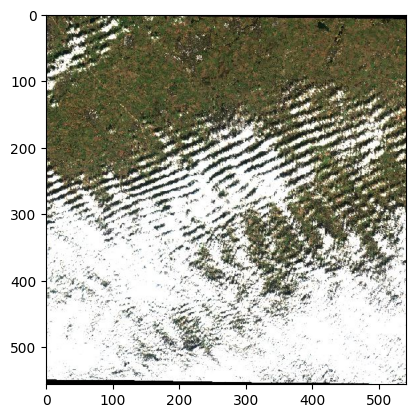

In [25]:
import matplotlib.pyplot as plt
import urllib
import numpy as np
from PIL import Image

# Some magic using pillow and urllib to open the remote jpg as a file handle in memory 
thumbnail = np.array(Image.open(urllib.request.urlopen(thumbnail_url)))

plt.imshow(thumbnail)

And we can load the geotiff in a similar fashion, using in this case the actual data file. Here I make an assumption about the name of the file involved based on the standard sentinel naming structure in the ceda archive (note: the keys on the asset dictionary may change in future updates to our STAC API).

In [26]:
data_file_url = [v.href for k, v in asset_dict.items() if 'utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif' in k][0]
data_file_url

'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/02/20/S2A_20230220_lat52lon075_T30UXC_ORB137_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif'

We can lazily load the geotiff with rioxarray, which will pull in the metadata from the url and only load when we want it to. All the sentinel2 data in our STAC catalogue is in Cloud-optimised Geotiff (COG) format, so it has several different layers of different resolutions that we can look at. In this case we tell rioxarray to load a lower resolution version of the image.

In [27]:
import rioxarray

rds = rioxarray.open_rasterio(data_file_url, overview_level=3)
rds

<xarray.DataArray (band: 10, y: 695, x: 676)>
[4698200 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 4.321e+05 4.322e+05 4.324e+05 ... 5.4e+05 5.402e+05
  * y            (y) float64 2.715e+05 2.713e+05 ... 1.605e+05 1.604e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

If the above has worked you should now see a summary of the dataset. It has 10 695x676 images in it corresponding to one for each band. If we look in the attributes we can often see that the name of each band is displayed in the `long_name` key, though sometimes you may have to dig through the metadata xml file to get that information. 

If necessary, we could get the metadata xml file name from the assets like so: 

In [28]:
meta_assets = [v for k, v in asset_dict.items() if 'meta.xml' in k]
meta_file_url = meta_assets[0].href


And then use something like `beautiful_soup` to parse the xml and find the band information. 

For now though, we can just take a quick look at one of the bands – 7: near infrared – with the following:  
**warning: this can take a while depending on your internet connection**

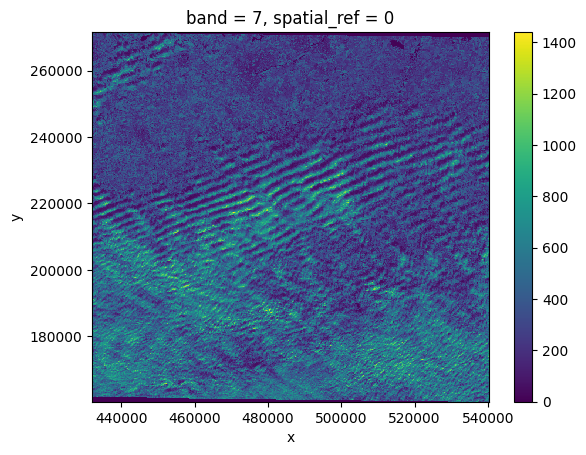

In [29]:
# Band=7 in this corresponds to the nir band, the ::100 downsamples by a factor of 100
rds.sel(band=7).plot()

This can now be manipulated to your hearts content, potentially with the missing values masked out etc. 

## 4. Searching and using NetCDF data

We can construct a search for NetCDF data in much the same way we constructed one for sentinel data. First we can grab the CMIP6 collection to get an idea of what we're looking at

In [30]:
cmip6_coll = client.get_collection('cmip6')
cmip6_coll.extent.to_dict()

{'spatial': {'bbox': [[-180.0, -90.0, 179.99999991618097, 89.99999995809048]]},
 'temporal': {'interval': [['1850-01-01T00:00:00Z', '4114-12-16T12:00:00Z']]}}

Here we construct a search call where we specify start and end datetime as before, but because CMIP datasets are wide we're trying to make sure our month of October is within teh start and end datetime, rather than last time where we wanted satellite images, taken at a single point in time, which occurred within our month. I'm also specifying an experiment here so we can see the different items available for a given run of a model.

Note we're using the same point we defined before. 

In [31]:
item_search = client.search(
    collections=['cmip6'],
    intersects=point,
    query=[
        'start_datetime<=2023-01-01',
        'end_datetime>=2023-02-28',
        'experiment_id=ssp585',
    ],
    max_items=10,
)

In [33]:
item_search.matched()

1213

And our reduced list of items looks like:

In [34]:
items = list(item_search.items())
items

[<Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.vas.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.uas.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.tas.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.psl.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.prsn.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.pr.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.huss.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.hurs.gn.v20190731>,
 <Item id=CMIP6.ScenarioMIP.THU.CIESM.ssp585.r1i1p1f1.Amon.tasmin.gr.v20200605>,
 <Item id=CMIP6.ScenarioMIP.THU.CIESM.ssp585.r1i1p1f1.Amon.tasmax.gr.v20200605>]

We can take a look at a particular item and the assets associated with it

In [35]:
item = items[0]
item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.vas.gn.v20190731',
 'properties': {'start_datetime': '2015-01-17T00:00:00',
  'end_datetime': '2100-12-17T00:00:00',
  'created': '2023-11-29T16:17:55.460766+00:00',
  'updated': '2023-11-29T16:17:55.460766+00:00',
  'datetime': None,
  'activity_id': 'ScenarioMIP',
  'instance_id': 'CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.vas.gn.v20190731',
  'pid': None,
  'data_specs_version': '01.00.28',
  'mip_era': 'CMIP6',
  'replica': False,
  'sub_experiment_id': 'none',
  'table_id': 'Amon',
  'retracted': False,
  'experiment_id': 'ssp585',
  'levels': None,
  'access': ['HTTPServer'],
  'institution_id': 'UA',
  'grid': 'lat-lon',
  'cf_standard_name': 'northward_wind',
  'variable_id': 'vas',
  'citation_url': 'http://cera-www.dkrz.de/WDCC/meta/CMIP6/CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.vas.gn.v20190731.json',
  'grid_label': 'gn',
  'source_type': 'AOGCM'

In [36]:
item.assets

{'reference_file': <Asset href=https://dap.ceda.ac.uk/badc/cmip6/metadata/kerchunk/by_dset/CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/CMIP6.ScenarioMIP.UA.MCM-UA-1-0.ssp585.r1i1p1f2.Amon.vas.gn.v20190731.zstd>,
 'vas_Amon_MCM-UA-1-0_ssp585_r1i1p1f2_gn_201501-210012.nc': <Asset href=https://dap.ceda.ac.uk/badc/cmip6/data/CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/vas/gn/v20190731/vas_Amon_MCM-UA-1-0_ssp585_r1i1p1f2_gn_201501-210012.nc>}

In [37]:
# Get the first asset whose key ends in '.nc'
nc_assets = [v.href for k, v in item.assets.items() if k[-3:]=='.nc']
nc_file_url = nc_assets[0]
nc_file_url

'https://dap.ceda.ac.uk/badc/cmip6/data/CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/vas/gn/v20190731/vas_Amon_MCM-UA-1-0_ssp585_r1i1p1f2_gn_201501-210012.nc'

As you can see, we only have two assets:
1. A reference file 
2. The netcdf file containing the data we want

Now we want to open that .nc file that contains the data, but there's not many nice ways to load NetCDF files over the internet without just downloading the whole thing. Ideally there would be a kerchunk file present to provide an index to the file to slice only the bits you want, and CEDA is currently working towards providing this solution but it's not quite ready yet. We could also provide zarr files which offer a nice soltuion to this, but would require making copies of all of the netcdf files currently stored in the CEDA archive, which we have no current plans to do. 

So in the mean time the only solutions we have are to either access the file on a machine which has the file mounted (the JASMIN notebook service could work) or to simply download the file. 

It should be noted that we have used xarray in this notebook, which is a great tool with [extensive documentation](https://docs.xarray.dev/en/stable/user-guide/io.html), but other tools, like `cf_python`, exist and could be used to equal effect. 

---
Watch this space for more information on how to read netcdf files remotely. 